# Modelling for VMC 

Below, we will introduce a couple of models. The first is Dense Autoencoders, these will be followed by GANs, then ResNet-like structure and, if time, permits we want to explore extensions of ResNets.

## AutoEncoder Basic Structure

In [37]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist, cifar10

In [38]:
class_labels = { 0: "T-shirt/top", 
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle-boot" 
            }

In [39]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

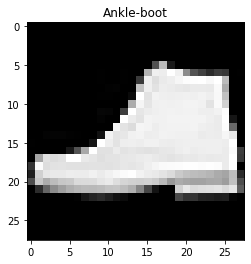

In [40]:
# show a random image from the training set
pixels, class_label = x_train[42], class_labels[y_train[42]]
plt.title(str(class_label))
plt.imshow(pixels, cmap='gray')
plt.show()

In [41]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, x_test.shape) 

(60000, 28, 28) (10000, 28, 28)


In [42]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [43]:
# First Encoder model

def Encoder(input_img):
    encoded = layers.Dense(128, activation='relu')(input_img)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)
    return encoded

In [44]:
# First Decoder model

def Decoder(encoded):
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(1, activation='sigmoid')(decoded)
    return decoded

In [45]:
# First Autoencoder model

input = Input(shape=(28, 28, 1))
encoder = Encoder(input)
decoder = Decoder(encoder)
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dense_10 (Dense)            (None, 28, 28, 128)       256       
                                                                 
 dense_11 (Dense)            (None, 28, 28, 64)        8256      
                                                                 
 dense_12 (Dense)            (None, 28, 28, 32)        2080      
                                                                 
 dense_13 (Dense)            (None, 28, 28, 64)        2112      
                                                                 
 dense_14 (Dense)            (None, 28, 28, 128)       8320      
                                                                 
 dense_15 (Dense)            (None, 28, 28, 1)         129   

In [46]:
autoencoder.fit(x_train, x_train, epochs = 1, batch_size = 64, validation_data = (x_test, x_test)) 

938/938 [==============================] - 112s 118ms/step - loss: 0.2641 - val_loss: 0.2431


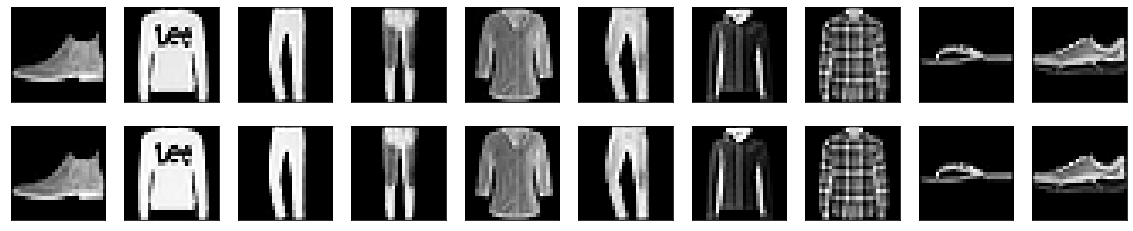

In [47]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show() 

## Generative Adversarial Nets' Basic Structure

In [535]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from auxiliaries.class_struct import GAN 

In [254]:

#params
image_size = (28,28,1)
n_train =int(60000/128)
n_test = int(10000/128)
N_Z = 64

# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(128)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(128)
)

In [255]:

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [256]:
def build_mode(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

model=build_mode(generator, discriminator)

In [257]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 1
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_train), test_dataset), total=n_train
    ):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    



 17%|█▋        | 79/468 [00:06<00:31, 12.21it/s]

Epoch: 0 | disc_loss: 1.1647601127624512 | gen_loss: 0.6394561529159546


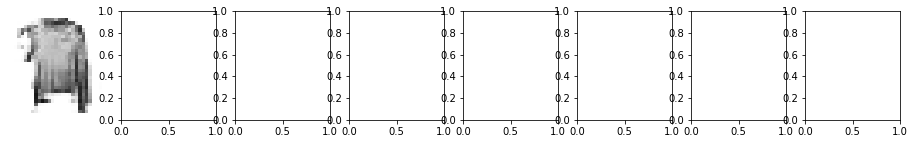

In [53]:
samples = model.generate(tf.random.normal(shape=(128, N_Z)))
nex=8
zm=2
fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
for axi in range(nex):
    axs[axi].matshow(
                samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
    axs[axi].axis('off')
    plt.show()

## Residual Networks

In [1]:

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from auxiliaries.class_struct import ResidualBlock

dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
batch_size = 128

def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

2022-03-28 12:40:24.493045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

class ResNet(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]

        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model = ResNet((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()




Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                           

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')
test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')



In [8]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)

In [9]:
import time
num_epoch = 1
start_time = time.time()
train_accuracies = []
test_accuracies = []
for epoch in range(num_epoch):    
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size =2):
            train_step(_image, _label)
            break
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Loss: 2.306979179382324, Accuracy: 10.234541893005371, Test Loss: 2.30441951751709, Test Accuracy: 10.0, spent_time: 1.865443515777588 min


## Data Form Reduction

### TODO : Tuning.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from auxiliaries.class_struct import GAN 
from sklearn.decomposition import PCA


In [5]:
# params
n_batch = 128
image_size = (28, 28, 1)
n_train = int(60000 / n_batch)
n_test = int(10000 / n_batch)
N_Z = 64
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = train_images.reshape(60000, 28 * 28)
X_test = test_images.reshape(10000, 28 * 28)

In [6]:
#PCA reduction
pca = PCA(n_components=0.95)
pca = pca.fit(X_train)
X_reduced = pca.transform(X_train)
Xtest_red = pca.transform(X_test)
# reconstruct data from compressed data
pca = PCA(n_components=X_reduced.shape[1])
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
Xtest_rec = pca.inverse_transform(Xtest_red)

non-compressed image


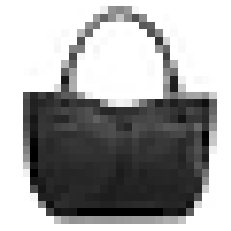

In [7]:
print("non-compressed image")
plt.imshow(X_train[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()



95% variance compressed image


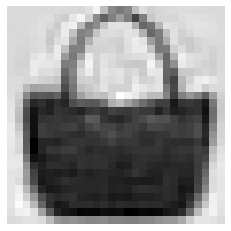

In [8]:
print("95% variance compressed image")
plt.imshow(X_recovered[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


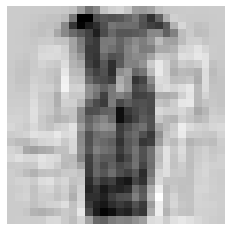

In [9]:

print("95% variance compressed image")
plt.imshow(Xtest_rec[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


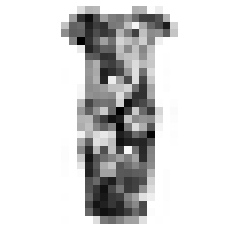

In [11]:

print("95% variance compressed image")
plt.imshow(X_test[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [12]:
test_images=Xtest_rec
train_images=X_recovered


2022-03-29 18:15:51.816235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


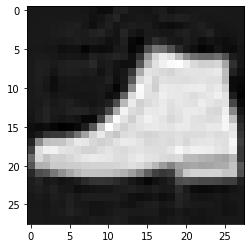

In [13]:
# split dataset
train_images = train_images.reshape(train_images.shape[0], *image_size).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], *image_size).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(n_batch)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(n_batch)
)
pixels = train_images[42]
plt.imshow(pixels, cmap='gray')
plt.show()

In [60]:
generator = [
    tf.keras.layers.Dense(units=7 *7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [61]:
def build_mode(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

model=build_mode(generator, discriminator)

100%|██████████| 78/78 [00:07<00:00, 10.90it/s]

Epoch: 0 | disc_loss: 1.3729147911071777 | gen_loss: 0.9315688014030457


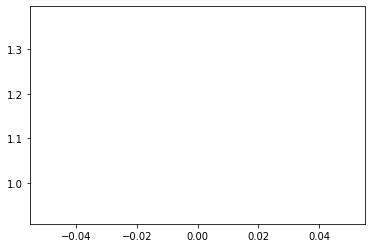

100%|██████████| 78/78 [00:06<00:00, 11.98it/s]

Epoch: 1 | disc_loss: 1.5183088779449463 | gen_loss: 0.47767987847328186


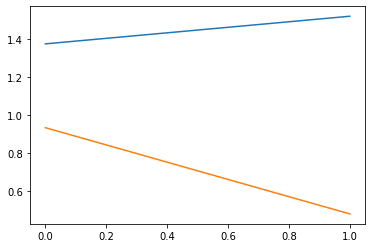

100%|██████████| 78/78 [00:06<00:00, 11.54it/s]

Epoch: 2 | disc_loss: 1.6101986169815063 | gen_loss: 0.8477201461791992


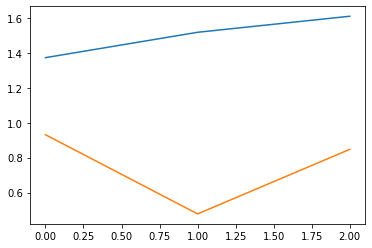

100%|██████████| 78/78 [00:06<00:00, 12.00it/s]

Epoch: 3 | disc_loss: 1.4361563920974731 | gen_loss: 0.9379589557647705


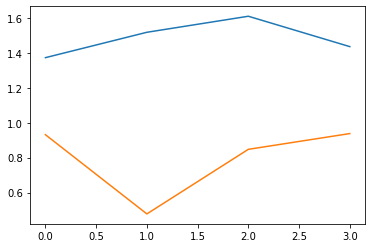

100%|██████████| 78/78 [00:06<00:00, 11.61it/s]


Epoch: 4 | disc_loss: 2.2411279678344727 | gen_loss: 0.23621536791324615


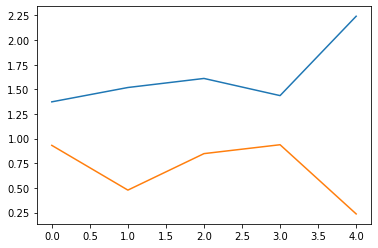

100%|██████████| 78/78 [00:06<00:00, 11.58it/s]

Epoch: 5 | disc_loss: 1.5631638765335083 | gen_loss: 0.448161780834198


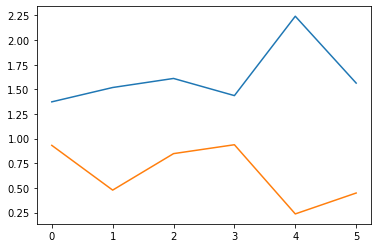

100%|██████████| 78/78 [00:07<00:00, 10.88it/s]


Epoch: 6 | disc_loss: 1.4091370105743408 | gen_loss: 0.8392904996871948


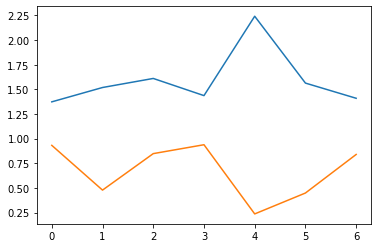

100%|██████████| 78/78 [00:06<00:00, 11.45it/s]


Epoch: 7 | disc_loss: 1.581122875213623 | gen_loss: 0.8896533250808716


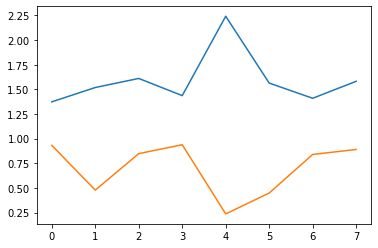

100%|██████████| 78/78 [00:06<00:00, 11.48it/s]


Epoch: 8 | disc_loss: 1.4927302598953247 | gen_loss: 0.8845443725585938


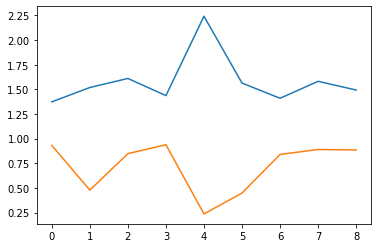

100%|██████████| 78/78 [00:06<00:00, 11.25it/s]

Epoch: 9 | disc_loss: 1.4251344203948975 | gen_loss: 0.7911093831062317


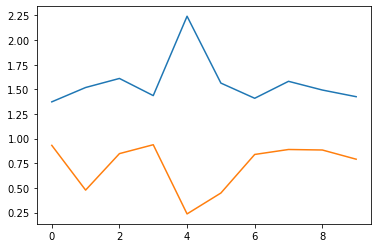

100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch: 10 | disc_loss: 1.3711172342300415 | gen_loss: 0.7150171995162964


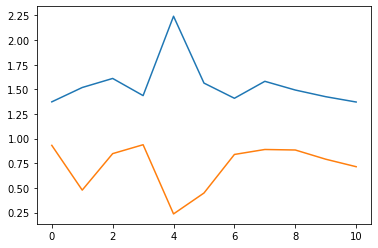

100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch: 11 | disc_loss: 1.3852800130844116 | gen_loss: 0.6991284489631653


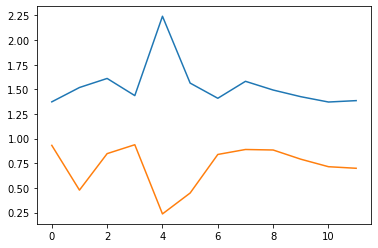

100%|██████████| 78/78 [00:07<00:00, 10.88it/s]


Epoch: 12 | disc_loss: 1.3904337882995605 | gen_loss: 0.7031022906303406


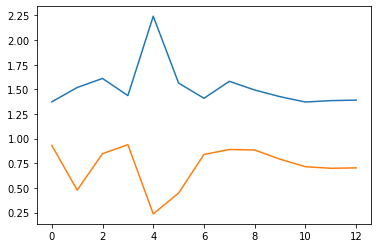

100%|██████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch: 13 | disc_loss: 1.4494684934616089 | gen_loss: 0.6744226217269897


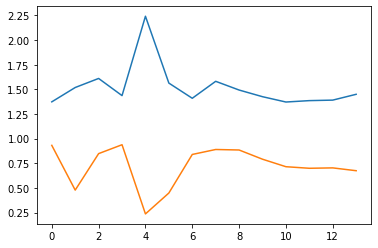

100%|██████████| 78/78 [00:06<00:00, 12.26it/s]

Epoch: 14 | disc_loss: 1.3863492012023926 | gen_loss: 0.6913965344429016


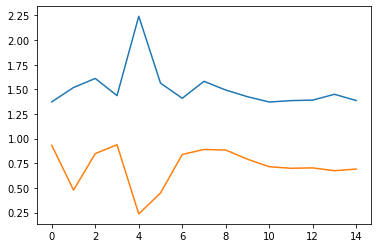

100%|██████████| 78/78 [00:06<00:00, 11.49it/s]


Epoch: 15 | disc_loss: 1.3866207599639893 | gen_loss: 0.6943972706794739


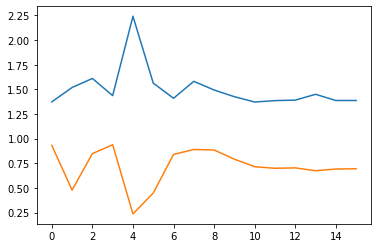

100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch: 16 | disc_loss: 1.3864967823028564 | gen_loss: 0.6943854689598083


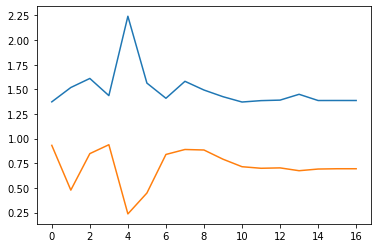

100%|██████████| 78/78 [00:07<00:00, 10.70it/s]


Epoch: 17 | disc_loss: 1.3864965438842773 | gen_loss: 0.6943854689598083


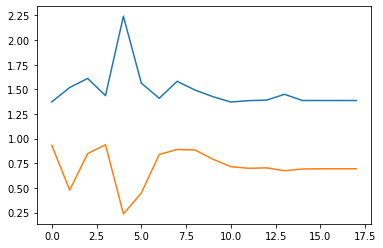

100%|██████████| 78/78 [00:07<00:00, 10.58it/s]


Epoch: 18 | disc_loss: 1.3864829540252686 | gen_loss: 0.6944049000740051


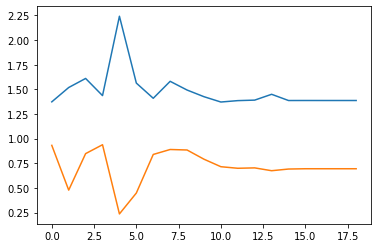

100%|██████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch: 19 | disc_loss: 1.386483073234558 | gen_loss: 0.6944049000740051


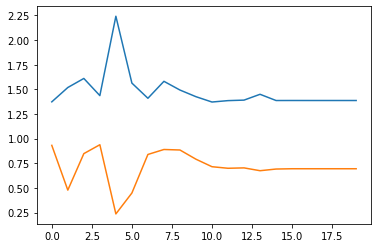

100%|██████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch: 20 | disc_loss: 1.3864829540252686 | gen_loss: 0.6944049000740051


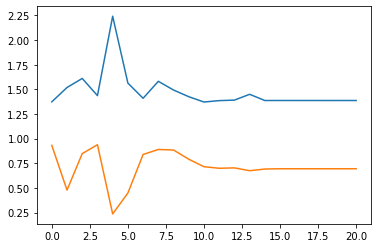

100%|██████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch: 21 | disc_loss: 1.386482834815979 | gen_loss: 0.6944049000740051


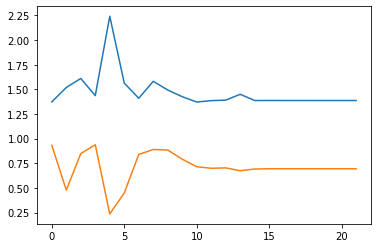

100%|██████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch: 22 | disc_loss: 1.3864833116531372 | gen_loss: 0.6944049000740051


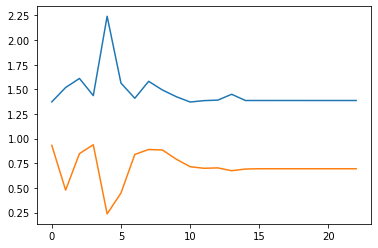

100%|██████████| 78/78 [00:07<00:00, 10.02it/s]


Epoch: 23 | disc_loss: 1.3864829540252686 | gen_loss: 0.6944049000740051


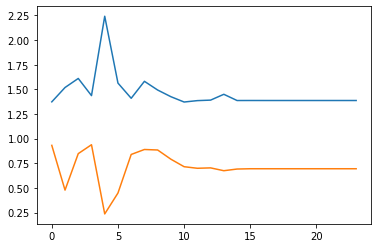

100%|██████████| 78/78 [00:08<00:00,  9.10it/s]


Epoch: 24 | disc_loss: 1.3864829540252686 | gen_loss: 0.6944049000740051


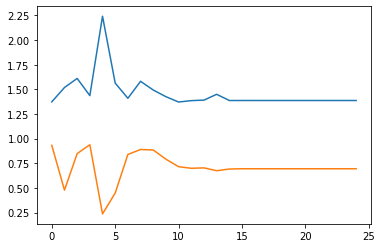

array([1.3729148, 1.5183089, 1.6101986, 1.4361564, 2.241128 , 1.5631639,
       1.409137 , 1.5811229, 1.4927303, 1.4251344, 1.3711172, 1.38528  ,
       1.3904338, 1.4494685, 1.3863492, 1.3866208, 1.3864968, 1.3864965,
       1.386483 , 1.3864831, 1.386483 , 1.3864828, 1.3864833, 1.386483 ,
       1.386483 ], dtype=float32)

In [64]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 25
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train

    ): 

        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_test), test_dataset), total=n_test
    ):
        loss.append(model.compute_loss(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plt.plot(losses.disc_loss.values)
    plt.plot(losses.gen_loss.values)
    plt.show()
    

losses.disc_loss.values   

In [27]:
losses.disc_loss.values   

array([3.0138261e-36, 1.5090504e-23, 1.1432478e-18, 2.4141096e-17,
       6.8588787e-13, 1.5091547e-15, 1.4583278e-13, 2.4117562e-14,
       1.4446736e-13, 1.1744491e-12, 2.3566092e-31, 2.2819979e-30,
       2.1199251e-25, 5.4158007e-24, 2.4350125e-21], dtype=float32)

TypeError: 'AxesSubplot' object is not subscriptable

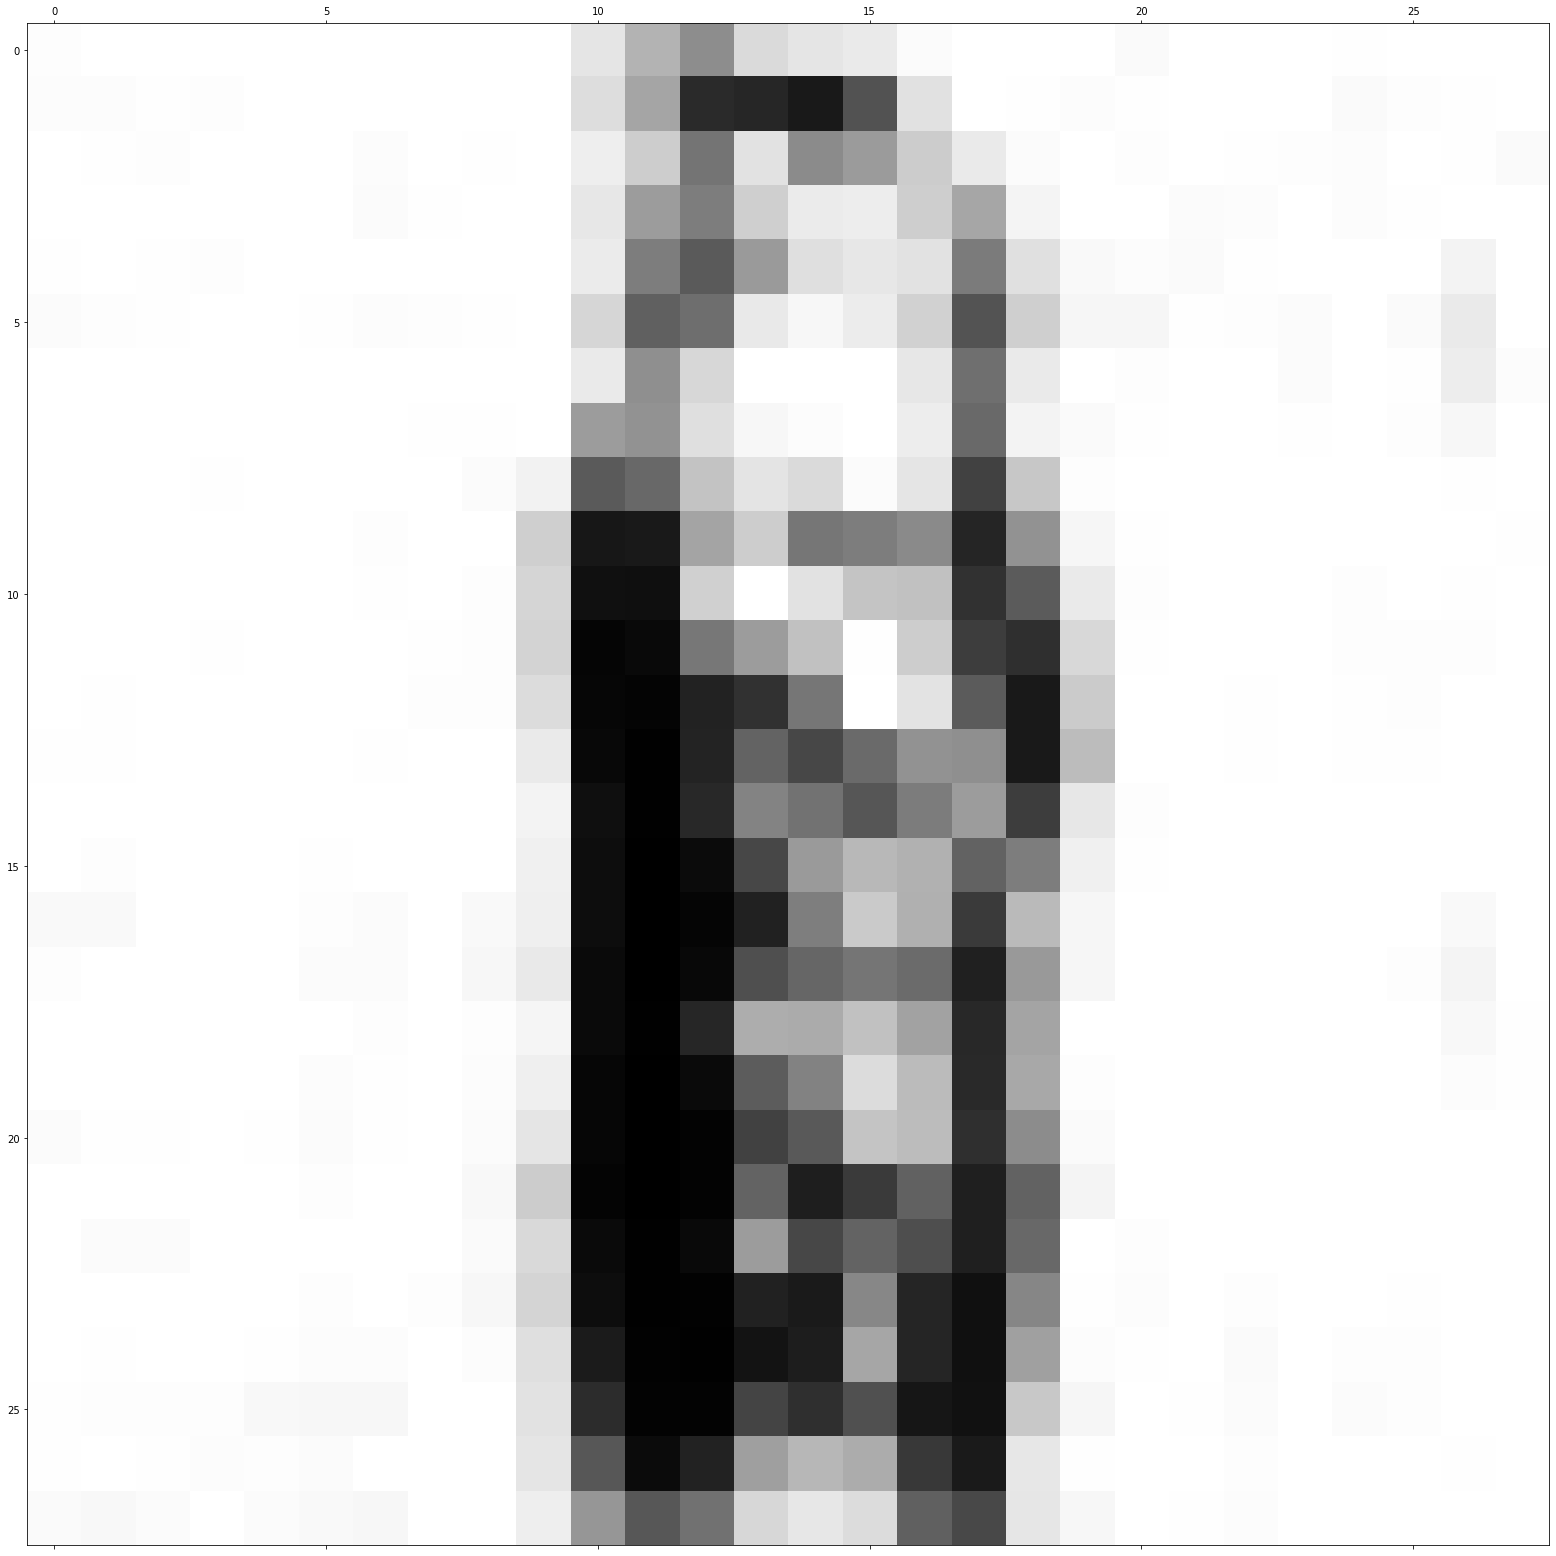

In [65]:

samples = model.generate(tf.random.normal(shape=(128, 28)))
nex=5
zm=28
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(zm * 5, zm))
for axi in range(1):

    axs.matshow(
                samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
    axs[axi].axis('off')
    plt.show()